# Training a Generative-Adversarial Network

In our previous chapters, we've focused on classification networks: taking an input and outputting a fixed label.  In this chapter, we'll examine generative networks: instead of simply classifying an image as containing a cat, these networks allow us to create new images of cats!  Cute lovers rejoice!

Most GAN research focuses on real life images from the CIFAR or ImageNet datasets.  For this section we'll pick a different type of image -- icons -- and see if we can generate realistic icons from scratch.

## Data collection

To train our GAN, we'll need a set of real icons to compare against.  Unfortunately, no such download is trivially available, so you'll have to do a little bit of manual work to acquire the data.

Start here: https://icons8.com/app/ and download the app.  Open up the resulting DMG image, right click, and select "Show Package Contents".  Now copy out the resources/icons.tar.gz file to somewhere on your file system and extract the contents.  We'll assume it's at ~/.cache/dl-cookbook/icons/.

## Loading the data

Our icon data is store as a LevelDB database.  Python wrappers exist for LevelDB, making it easy to read.  Each icon record is in a custom format which we don't have a parser for.  We'll do our best to pull out the information we want: namely, the category and icon SVG itself.  Fortunately, the format appears to be consistent across the vast majority of the icons -- we ignore any icons we can't parse.

In [10]:
DB_LOCATION = os.path.expanduser('~/.cache/dl-cookbook/icons/')

import leveldb
ldb = leveldb.LevelDB(DB_LOCATION)

In [173]:
import itertools, io
import numpy as np
from cairosvg import svg2png
from PIL import Image

noise_size = 10
img_width = 64
img_height = 64

images = []
categories = []

l_iter = ldb.RangeIter(None, None)
for i, (k, v) in enumerate(l_iter):
    if i % 100 == 0:
        print('\r%05d: %s' % (i, k), end='', flush=True)
        
    try:
        cat = v.replace(b'\x00', b'').split(b'\x08')[2].decode('utf8')
        
        start_idx = v.find(b'<?xml')
        end_idx = v.find(b'</svg>')
        v = v[start_idx:end_idx+6]    
        png = svg2png(bytestring=bytes(v))        
        
        with io.BytesIO(png) as f:
            img = Image.open(f)
            img = img.resize((img_width, img_height))
            img = np.asarray(img)
            images.append(img)
            categories.append(cat)
    except:
        print('Bad: ', k, v[:10], sys.exc_info())
        continue

02700: bytearray(b'icon_12554')Bad:  bytearray(b'icon_12570') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x11f6ab948>)
Bad:  bytearray(b'icon_12571') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x11f6abb48>)
Bad:  bytearray(b'icon_12613') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x11f52a248>)
Bad:  bytearray(b'icon_12615') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x1240f1c48>)
09900: bytearray(b'icon_19253')Bad:  bytearray(b'icon_19261') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x3e7242108>)
Bad:  bytearray(b'icon_19262') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x3e7231d08>)
11800: bytearray(b'icon_21

20800: bytearray(b'icon_35465')Bad:  bytearray(b'icon_35572') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x11627b5c8>)
20900: bytearray(b'icon_35599')Bad:  bytearray(b'icon_35617') (<class 'urllib.error.URLError'>, URLError(FileNotFoundError(2, 'No such file or directory'),), <traceback object at 0x11627a708>)
Bad:  bytearray(b'icon_35621') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x1afac1388>)
Bad:  bytearray(b'icon_35622') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x11627da48>)
Bad:  bytearray(b'icon_35623') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x11627d608>)
Bad:  bytearray(b'icon_35624') (<class 'urllib.error.URLError'>, URLError(IsADirectoryError(21, 'Is a directory'),), <traceback object at 0x11626db08>)
Bad:  bytearray(

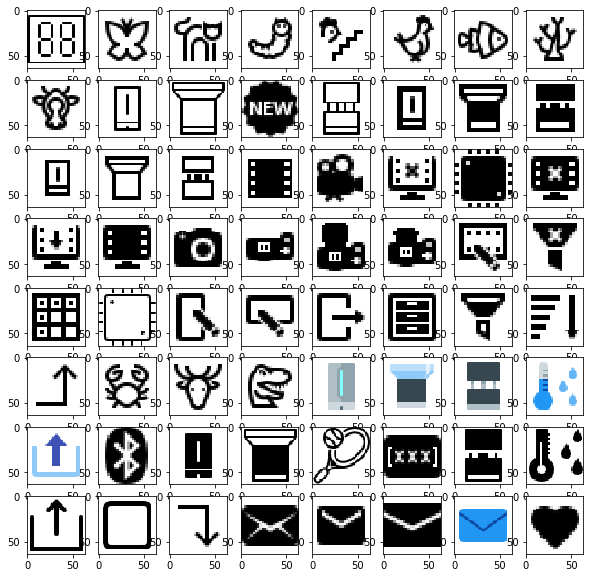

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
f, axarr = plt.subplots(8, 8)
f.set_size_inches(10, 10)
for i in range(8):
    for j in range(8):
        axarr[i, j].imshow(images[10000 + i * 8 + j])

## Prepping our data

Before training our network, we want to normalize our data to make the models work a little easier: we'll normalize all of our images to have values between -1 and 1.  We'll also transform our categories we collected up above into labels from [0, num_labels].  We will use these labels to pre-train our discriminator network.

In [175]:
img_array = np.asarray(
    [2 * (img / (1e-9 + img.max()) - 0.5) for img in images]
)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(categories)

In [178]:
len(category_labels), len(img_array)

(38544, 38544)

In [182]:
## Let's take a quick look at what our categories are like.

collections.Counter(categories)

Counter({'': 1,
         'Alphabet': 552,
         'Animals': 738,
         'Arrows': 824,
         'Astrology': 379,
         'Baby': 361,
         'Beauty': 428,
         'Business': 1622,
         'Cinema': 1199,
         'City': 1015,
         'Clothing': 540,
         'Computer Hardware': 495,
         'Crime': 115,
         'Culture': 494,
         'DIY': 277,
         'Data': 919,
         'Drinks': 197,
         'Ecommerce': 1100,
         'Editing': 1310,
         'File Types': 2,
         'Files': 901,
         'Finance': 631,
         'Flags': 232,
         'Folders': 165,
         'Food': 864,
         'Free Popular': 576,
         'Gaming': 824,
         'Hands': 214,
         'Healthcare': 751,
         'Holidays': 454,
         'Household': 1587,
         'Industry': 949,
         'Logos': 2091,
         'Maps': 555,
         'Media Controls': 287,
         'Messaging': 1187,
         'Military': 483,
         'Mobile': 613,
         'Music': 504,
         'Nature': 12,


## Building our network

Now that we have our icons, let's build our GAN network.  The basic idea with a GAN network is to construct 2 sub-networks that we will have "fight" against each other.

* Generator: this network starts with a random data seed, and it's goal is to generate an image that fools the discriminator
* Discriminator: this network is presented an image, and must decide whether it is a real image, or a fake generated by the generator network

By playing these networks against each other, we can cause the generator network to produce more and more convincing "fakes".

### Generator Network

Our generator network is effectively an upside down convolutional network.  Normal CNNs start with an image and producing a small dimensional label.  A generative network starts with a small random seed ("label"), and runs inverted CNN to produce successively larger images.

In [131]:
import keras
from keras.models import Model
import keras.layers as L
import keras.backend as K


# Using https://github.com/ctmakro/hellotensor/blob/master/lets_gan_clean.py
# as a basis

def build_gen_network(seed_shape):
    input = L.Input(shape=(seed_shape,))
    reshaped = L.Reshape((1,1,seed_shape))(input)
    
    def deconv(layer, num_filters, kernel_size, strides=4, normalize=True, padding='same'):
        layer = L.Conv2DTranspose(
            num_filters, kernel_size, 
            padding=padding,
            strides=strides)(layer)
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
        return layer

    reshaped = deconv(reshaped, 256, 4, padding='valid', strides=2)
    reshaped = deconv(reshaped, 128, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 128, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 64, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 4, 4, normalize=False, strides=2)    
    reshaped = L.Activation(activation='tanh')(reshaped)
    
    return Model(inputs=[input], outputs=[reshaped])

gen_network = build_gen_network(noise_size)
gen_network.compile(loss='binary_crossentropy', optimizer='adam')
gen_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 10)                0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 1, 1, 10)          0         
_________________________________________________________________
conv2d_transpose_57 (Conv2DT (None, 4, 4, 256)         41216     
_________________________________________________________________
batch_normalization_71 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_58 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_72 (Batc (None, 8, 8, 128)         512       
__________

### Discriminator Network

Our discriminator network is just a standard CNN, and looks like the inverse of our generator.  We stack a number of CNN layers, terminating in dense layer with a single output to decide if we are looking at a real or fake image.

In [180]:
def build_discriminator_network():
    input = L.Input(shape=(img_width, img_height, 4))
    def conv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2D(
            num_filters, kernel_size, 
            padding=padding,
            strides=strides)(layer)
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
        return layer
    
    l = conv(input, 64, kernel_size=4, strides=2)
    l = conv(l, 128, kernel_size=4, strides=2)
    l = conv(l, 256, kernel_size=4, strides=2)
    l = conv(l, 256, kernel_size=4, strides=2)
    l = L.Flatten()(l)
    l = L.Dense(units=64, activation='relu')(l)
    
    discriminator = L.Dense(units=1, activation='sigmoid')(l)
    label = L.Dense(units=len(label_encoder.classes_))(l)
    
    return (
        Model(inputs=[input], outputs=[discriminator]),
        Model(inputs=[input], outputs=[label]),
    )

dis_net, label_net = build_discriminator_network()
label_net.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
dis_net.compile(loss='binary_crossentropy', optimizer='adam')
dis_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        4160      
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_80 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 16, 16, 128)       0         
__________

### Combined Model

Now let's build the combined model which runs both our generator and discrimnator: this will be used for training.

In [114]:
gan_input = L.Input(gen_network.input_shape[1:])
GAN = Model(gan_input, 
            discriminator_network(gen_network(gan_input)))
GAN.compile(loss='binary_crossentropy', optimizer='adam')
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 10)                0         
_________________________________________________________________
model_18 (Model)             (None, 64, 64, 4)         965444    
_________________________________________________________________
model_20 (Model)             (None, 1)                 1973825   
Total params: 2,939,269
Trainable params: 2,936,709
Non-trainable params: 2,560
_________________________________________________________________


In [128]:
class Stat(object):
    def __init__(self):
        self._v = []
        
    def record(self, v):
        self._v.append(v)
        
    def mean(self, last=10):
        return np.mean(self._v[-last:])

## Pretraining our discriminator network

To help our real training converge faster, we pre-train our discriminator network to determine which category an icon comes from.  Because the label network shares most of it's layers with the discriminator network, most of the discriminator network will have reasonable values.

In [181]:
label_net.fit(
    img_array, category_labels
)

Epoch 1/1
 2176/38544 [>.............................] - ETA: 1062s - loss: 9.2572

KeyboardInterrupt: 

## Training the GAN

Now we're finally ready to train the generator network.  We do this by alternating the following:

* Generate a batch of images G
* Train the discriminator to distinguish true images from G
* Generate a new batch G'
* Train the generator based on how well G' fooled the discriminator

In [183]:
batch_size = 8
noise_size = 10

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

d_loss = Stat()
g_loss = Stat()

for i in range(100):
    noise_gen = np.random.uniform(0, 1, size=(batch_size, noise_size))
    image_batch = normalized_img[np.random.randint(0, normalized_img.shape[0], size=batch_size)]
    
    # Train the discriminator network
    generated = gen_network.predict(noise_gen)
    make_trainable(discriminator_network, True)
    
    # Use separate batches for true and fake images
    d_loss.record(discriminator_network.train_on_batch(image_batch, np.ones(batch_size)))
    d_loss.record(discriminator_network.train_on_batch(generated, np.zeros(batch_size)))
    
    # Now train the generator network -- it should generate inputs which
    # "fool" the discriminator and cause it to produce 1s.
    noise_tr = np.random.uniform(0, 1, size=(batch_size, noise_size))
    y2 = np.zeros(batch_size)
    y2[:] = 1
    make_trainable(discriminator_network, False)
    g_loss.record(GAN.train_on_batch(noise_tr, y2))
    
    print('\r', i, 'G: %.8f D: %.8f' % (g_loss.mean(), d_loss.mean()), flush=True, end='')

 99 G: 0.00000012 D: 0.00000022

In [184]:
g_loss